# Rule Mining in Family Relations Knowledge Graph

Discovering logical rules that encode family relationships. This notebook automatically discovers Horn clauses, inverse rules, and complex compositional patterns that hold in the MetaFam knowledge graph.

In [2]:
import networkx as nx
from collections import defaultdict, Counter
import pandas as pd
import numpy as np
from IPython.display import HTML, display
import matplotlib.pyplot as plt
from itertools import combinations

# Load the data
FILE_PATH = "train.txt"

def load_data(filepath):
    """Load family relations from file"""
    relations = []
    people = set()
    
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 3:
                continue
            
            p1, relation, p2 = parts
            relations.append((p1, relation, p2))
            people.add(p1)
            people.add(p2)
    
    return people, relations

people, relations = load_data(FILE_PATH)
total_relations = len(relations)

# Build indexes for quick lookup
relations_by_type = defaultdict(set)  # relation_type -> set of (p1, p2)
relations_by_pair = defaultdict(set)  # (p1, p2) -> set of relation_types

for p1, rel, p2 in relations:
    relations_by_type[rel].add((p1, p2))
    relations_by_pair[(p1, p2)].add(rel)

print(f"✓ Data loaded successfully")
print(f"  • Total people: {len(people)}")
print(f"  • Total relations: {total_relations}")
print(f"  • Unique relation types: {len(relations_by_type)}")
print(f"\nRelation types found:")
for rel_type in sorted(relations_by_type.keys()):
    print(f"  • {rel_type}: {len(relations_by_type[rel_type])} instances")

✓ Data loaded successfully
  • Total people: 1316
  • Total relations: 13821
  • Unique relation types: 28

Relation types found:
  • auntOf: 556 instances
  • boyCousinOf: 391 instances
  • boyFirstCousinOnceRemovedOf: 180 instances
  • boySecondCousinOf: 68 instances
  • brotherOf: 570 instances
  • daughterOf: 628 instances
  • fatherOf: 733 instances
  • girlCousinOf: 445 instances
  • girlFirstCousinOnceRemovedOf: 153 instances
  • girlSecondCousinOf: 62 instances
  • granddaughterOf: 812 instances
  • grandfatherOf: 813 instances
  • grandmotherOf: 813 instances
  • grandsonOf: 814 instances
  • greatAuntOf: 312 instances
  • greatGranddaughterOf: 610 instances
  • greatGrandfatherOf: 617 instances
  • greatGrandmotherOf: 617 instances
  • greatGrandsonOf: 624 instances
  • greatUncleOf: 237 instances
  • motherOf: 733 instances
  • nephewOf: 514 instances
  • nieceOf: 496 instances
  • secondAuntOf: 175 instances
  • secondUncleOf: 158 instances
  • sisterOf: 636 instances
  • s

## Rule Type 1: Inverse Rules

An inverse rule states: If relation1(X, Y) exists, then relation2(Y, X) should exist.
Example: If (Alice, siblingOf, Bob) then (Bob, siblingOf, Alice)

In [ ]:
def discover_inverse_rules(relations_by_type, relations_by_pair, relations):
    """
    Discover inverse rules: rel1(X,Y) → rel2(Y,X)
    """
    inverse_rules = []
    
    # Check all pairs of relation types
    for rel1 in relations_by_type:
        for rel2 in relations_by_type:
            if rel1 == rel2:
                continue  
            
            # Count how many times rel1(X,Y) implies rel2(Y,X)
            matches = 0
            potential = len(relations_by_type[rel1])
            examples = []
            
            for (x, y) in relations_by_type[rel1]:
                if (y, x) in relations_by_pair and rel2 in relations_by_pair[(y, x)]:
                    matches += 1
                    if len(examples) < 3:
                        examples.append((x, y))
            
            if potential > 0 and matches > 0:
                confidence = matches / potential
                support = matches / len(relations)
                
                if confidence >= 0.5:  # Only keep rules with at least 50% confidence
                    inverse_rules.append({
                        'Rule Type': 'Inverse',
                        'Rule': f'{rel1}(X,Y) → {rel2}(Y,X)',
                        'Head Relation': rel2,
                        'Body Relation': rel1,
                        'Confidence': confidence,
                        'Support': support,
                        'Instances': matches,
                        'Potential_Matches': potential,
                        'Examples': examples
                    })
    
    return sorted(inverse_rules, key=lambda x: x['Confidence'], reverse=True)

inverse_rules = discover_inverse_rules(relations_by_type, relations_by_pair, relations)

print(f"🔍 Discovered {len(inverse_rules)} inverse rules\n")

for rule in inverse_rules[:5]:  
    print(f"Rule: {rule['Rule']}")
    print(f"  Confidence: {rule['Confidence']:.2%} ({rule['Instances']}/{rule['Potential_Matches']})")
    print(f"  Support: {rule['Support']:.2%} (in {rule['Instances']} of {total_relations} relations)")
    print(f"  Examples:")
    for x, y in rule['Examples']:
        print(f"    • {rule['Body Relation']}({x}, {y}) → {rule['Head Relation']}({y}, {x})")
    print()

🔍 Discovered 25 inverse rules

Rule: girlSecondCousinOf(X,Y) → boySecondCousinOf(Y,X)
  Confidence: 64.52% (40/62)
  Support: 0.29% (in 40 of 13821 relations)
  Examples:
    • girlSecondCousinOf(lena18, fabian26) → boySecondCousinOf(fabian26, lena18)
    • girlSecondCousinOf(natalie89, lukas93) → boySecondCousinOf(lukas93, natalie89)
    • girlSecondCousinOf(valentina201, simon210) → boySecondCousinOf(simon210, valentina201)

Rule: boySecondCousinOf(X,Y) → girlSecondCousinOf(Y,X)
  Confidence: 58.82% (40/68)
  Support: 0.29% (in 40 of 13821 relations)
  Examples:
    • boySecondCousinOf(samuel463, hannah467) → girlSecondCousinOf(hannah467, samuel463)
    • boySecondCousinOf(nico91, emily102) → girlSecondCousinOf(emily102, nico91)
    • boySecondCousinOf(leo1304, beate1302) → girlSecondCousinOf(beate1302, leo1304)

Rule: nephewOf(X,Y) → auntOf(Y,X)
  Confidence: 57.98% (298/514)
  Support: 2.16% (in 298 of 13821 relations)
  Examples:
    • nephewOf(julian1242, clara1239) → auntOf(clar

## Rule Type 2: Compositional Rules (2-hop)

A compositional rule states: If relation1(X, Y) and relation2(Y, Z) exist, then relation3(X, Z) should exist.
Example: If (Alice, motherOf, Bob) and (Bob, fatherOf, Charlie) then (Alice, grandmotherOf, Charlie)

In [ ]:
def discover_compositional_rules(relations_by_type, relations_by_pair):
    """
    Discover compositional rules: rel1(X,Y) ∧ rel2(Y,Z) → rel3(X,Z)
    """
    compositional_rules = []
    
    # Check all combinations of two relations
    relation_types = list(relations_by_type.keys())
    
    for rel1 in relation_types:
        for rel2 in relation_types:
            for rel3 in relation_types:
                # Build the 2-hop paths for rel1 and rel2
                paths = defaultdict(list) 
                xy_edges = relations_by_type[rel1]
                for (x, y) in xy_edges:
                    for (y_check, z) in relations_by_type[rel2]:
                        if y == y_check:
                            paths[(x, z)].append(y)
                matches = 0
                potential = len(paths)
                examples = []
                
                for (x, z), mediators in paths.items():
                    if (x, z) in relations_by_pair and rel3 in relations_by_pair[(x, z)]:
                        matches += 1
                        if len(examples) < 3:
                            examples.append((x, mediators[0], z))
                
                if potential > 0 and matches > 0:
                    confidence = matches / potential
                    support = matches / total_relations
                    
                    # Only keep meaningful rules (high confidence or high support)
                    if confidence >= 0.6 or (support >= 0.01 and matches >= 5):
                        compositional_rules.append({
                            'Rule Type': 'Compositional (2-hop)',
                            'Rule': f'{rel1}(X,Y) ∧ {rel2}(Y,Z) → {rel3}(X,Z)',
                            'Body_Rel1': rel1,
                            'Body_Rel2': rel2,
                            'Head Relation': rel3,
                            'Confidence': confidence,
                            'Support': support,
                            'Instances': matches,
                            'Potential_Matches': potential,
                            'Examples': examples
                        })
    
    return sorted(compositional_rules, key=lambda x: x['Confidence'], reverse=True)

compositional_rules = discover_compositional_rules(relations_by_type, relations_by_pair)

print(f"Discovered {len(compositional_rules)} compositional rules\n")

for rule in compositional_rules[:8]: 
    print(f"Rule: {rule['Rule']}")
    print(f"  Confidence: {rule['Confidence']:.2%} ({rule['Instances']}/{rule['Potential_Matches']})")
    print(f"  Support: {rule['Support']:.4%} (in {rule['Instances']} of {total_relations} relations)")
    print(f"  Examples:")
    for x, y, z in rule['Examples']:
        print(f"    • {rule['Body_Rel1']}({x}, {y}) ∧ {rule['Body_Rel2']}({y}, {z}) → {rule['Head Relation']}({x}, {z})")
    print()

🔍 Discovered 426 compositional rules

Rule: sisterOf(X,Y) ∧ secondAuntOf(Y,Z) → secondAuntOf(X,Z)
  Confidence: 100.00% (80/80)
  Support: 0.5788% (in 80 of 13821 relations)
  Examples:
    • sisterOf(magdalena782, sarah776) ∧ secondAuntOf(sarah776, lukas772) → secondAuntOf(magdalena782, lukas772)
    • sisterOf(magdalena782, sarah776) ∧ secondAuntOf(sarah776, oskar771) → secondAuntOf(magdalena782, oskar771)
    • sisterOf(lina1228, katharina1218) ∧ secondAuntOf(katharina1218, noah1232) → secondAuntOf(lina1228, noah1232)

Rule: sisterOf(X,Y) ∧ girlCousinOf(Y,Z) → girlCousinOf(X,Z)
  Confidence: 100.00% (263/263)
  Support: 1.9029% (in 263 of 13821 relations)
  Examples:
    • sisterOf(valentina1015, leonie1016) ∧ girlCousinOf(leonie1016, elias1010) → girlCousinOf(valentina1015, elias1010)
    • sisterOf(valentina1015, leonie1016) ∧ girlCousinOf(leonie1016, claudia1017) → girlCousinOf(valentina1015, claudia1017)
    • sisterOf(valentina1015, leonie1016) ∧ girlCousinOf(leonie1016, isabel

## Rule Type 3: Complex Rules (3-hop)

A complex 3-hop rule combines three relations: rel1(X, Y) ∧ rel2(Y, Z) ∧ rel3(Z, W) → rel4(X, W)
Example: If (Alice, motherOf, Bob) and (Bob, brotherOf, Charlie) and (Charlie, fatherOf, David) then (Alice, grandmotherOf, David)

In [ ]:
def discover_3hop_rules(relations_by_type, relations_by_pair):
    """
    Discover 3-hop compositional rules: rel1(X,Y) ∧ rel2(Y,Z) ∧ rel3(Z,W) → rel4(X,W)
    """
    complex_rules = []
    
    relation_types = list(relations_by_type.keys())
    from itertools import product
    rule_combos = list(product(relation_types, repeat=4))
    if len(rule_combos) > 5000:
        import random
        rule_combos = random.sample(rule_combos, 5000)
    
    for rel1, rel2, rel3, rel4 in rule_combos:
        paths = defaultdict(list)
        
        for (x, y) in relations_by_type[rel1]:
            for (y_check, z) in relations_by_type[rel2]:
                if y == y_check:
                    for (z_check, w) in relations_by_type[rel3]:
                        if z == z_check:
                            paths[(x, w)].append((y, z))
        matches = 0
        potential = len(paths)
        examples = []
        
        if potential > 0:
            for (x, w), path_list in paths.items():
                if (x, w) in relations_by_pair and rel4 in relations_by_pair[(x, w)]:
                    matches += 1
                    if len(examples) < 2:
                        y, z = path_list[0]
                        examples.append((x, y, z, w))
        
        if potential > 0 and matches > 0:
            confidence = matches / potential
            support = matches / total_relations
            
            # Keep rules with good confidence
            if confidence >= 0.7 and matches >= 3:
                complex_rules.append({
                    'Rule Type': 'Compositional (3-hop)',
                    'Rule': f'{rel1}(X,Y) ∧ {rel2}(Y,Z) ∧ {rel3}(Z,W) → {rel4}(X,W)',
                    'Body_Rels': [rel1, rel2, rel3],
                    'Head Relation': rel4,
                    'Confidence': confidence,
                    'Support': support,
                    'Instances': matches,
                    'Potential_Matches': potential,
                    'Examples': examples
                })
    
    return sorted(complex_rules, key=lambda x: x['Confidence'], reverse=True)

complex_rules = discover_3hop_rules(relations_by_type, relations_by_pair)

print(f"🔍 Discovered {len(complex_rules)} 3-hop compositional rules\n")

for rule in complex_rules[:5]:
    rels = rule['Body_Rels']
    print(f"Rule: {rule['Rule']}")
    print(f"  Confidence: {rule['Confidence']:.2%} ({rule['Instances']}/{rule['Potential_Matches']})")
    print(f"  Support: {rule['Support']:.4%} (in {rule['Instances']} of {total_relations} relations)")
    if rule['Examples']:
        print(f"  Examples:")
        for x, y, z, w in rule['Examples']:
            print(f"    • {rels[0]}({x}, {y}) ∧ {rels[1]}({y}, {z}) ∧ {rels[2]}({z}, {w}) → {rule['Head Relation']}({x}, {w})")
    print()

🔍 Discovered 36 3-hop compositional rules

Rule: granddaughterOf(X,Y) ∧ uncleOf(Y,Z) ∧ sisterOf(Z,W) → girlFirstCousinOnceRemovedOf(X,W)
  Confidence: 100.00% (43/43)
  Support: 0.3111% (in 43 of 13821 relations)
  Examples:
    • granddaughterOf(katharina889, luis868) ∧ uncleOf(luis868, larissa885) ∧ sisterOf(larissa885, thomas875) → girlFirstCousinOnceRemovedOf(katharina889, thomas875)
    • granddaughterOf(katharina889, luis868) ∧ uncleOf(luis868, paula881) ∧ sisterOf(paula881, dominik882) → girlFirstCousinOnceRemovedOf(katharina889, dominik882)

Rule: girlCousinOf(X,Y) ∧ sonOf(Y,Z) ∧ grandfatherOf(Z,W) → secondAuntOf(X,W)
  Confidence: 100.00% (120/120)
  Support: 0.8682% (in 120 of 13821 relations)
  Examples:
    • girlCousinOf(olivia1043, philipp1031) ∧ sonOf(philipp1031, matthias1030) ∧ grandfatherOf(matthias1030, maximilian1040) → secondAuntOf(olivia1043, maximilian1040)
    • girlCousinOf(maria653, jakob647) ∧ sonOf(jakob647, raphael642) ∧ grandfatherOf(raphael642, anna650) →

## Rule Summary

Comprehensive overview of all discovered rules with their confidence and support metrics.

In [ ]:

all_rules = inverse_rules + compositional_rules + complex_rules

summary_data = []
for rule in all_rules:
    summary_data.append({
        'Rule Type': rule['Rule Type'],
        'Rule': rule['Rule'],
        'Confidence': f"{rule['Confidence']:.2%}",
        'Support': f"{rule['Support']:.4%}",
        'Instances': rule['Instances'],
        'Potential': rule['Potential_Matches']
    })

summary_df = pd.DataFrame(summary_data)

display(HTML("<h3>Summary of All Discovered Rules</h3>"))
display(HTML(f"<p>Total rules discovered: <b>{len(all_rules)}</b></p>"))

# Display by rule type
for rule_type in ['Inverse', 'Compositional (2-hop)', 'Compositional (3-hop)', 'Mixed OR (Simple)', 'Mixed OR (Compositional)']:
    rules_of_type = summary_df[summary_df['Rule Type'] == rule_type]
    if len(rules_of_type) > 0:
        display(HTML(f"<h4>{rule_type} Rules ({len(rules_of_type)})</h4>"))
        display(rules_of_type[['Rule', 'Confidence', 'Support', 'Instances']].style.set_properties(**{'text-align': 'left'}))
        print()

,Rule,Confidence,Support,Instances
0,"girlSecondCousinOf(X,Y) → boySecondCousinOf(Y,X)",64.52%,0.2894%,40
1,"boySecondCousinOf(X,Y) → girlSecondCousinOf(Y,X)",58.82%,0.2894%,40
2,"nephewOf(X,Y) → auntOf(Y,X)",57.98%,2.1561%,298
3,"secondAuntOf(X,Y) → boyFirstCousinOnceRemovedOf(Y,X)",56.00%,0.7091%,98
4,"boyFirstCousinOnceRemovedOf(X,Y) → secondAuntOf(Y,X)",54.44%,0.7091%,98
5,"brotherOf(X,Y) → sisterOf(Y,X)",54.04%,2.2285%,308
6,"auntOf(X,Y) → nephewOf(Y,X)",53.60%,2.1561%,298
7,"boyCousinOf(X,Y) → girlCousinOf(Y,X)",53.45%,1.5122%,209
8,"uncleOf(X,Y) → nieceOf(Y,X)",52.42%,1.7220%,238
9,"nieceOf(X,Y) → auntOf(Y,X)",52.02%,1.8667%,258


,Rule,Confidence,Support,Instances
25,"sisterOf(X,Y) ∧ secondAuntOf(Y,Z) → secondAuntOf(X,Z)",100.00%,0.5788%,80
26,"sisterOf(X,Y) ∧ girlCousinOf(Y,Z) → girlCousinOf(X,Z)",100.00%,1.9029%,263
27,"sisterOf(X,Y) ∧ daughterOf(Y,Z) → daughterOf(X,Z)",100.00%,2.3804%,329
28,"sisterOf(X,Y) ∧ granddaughterOf(Y,Z) → granddaughterOf(X,Z)",100.00%,3.4440%,476
29,"sisterOf(X,Y) ∧ nieceOf(Y,Z) → nieceOf(X,Z)",100.00%,1.8957%,262
30,"sisterOf(X,Y) ∧ motherOf(Y,Z) → auntOf(X,Z)",100.00%,1.6786%,232
31,"sisterOf(X,Y) ∧ grandmotherOf(Y,Z) → greatAuntOf(X,Z)",100.00%,0.8104%,112
32,"sisterOf(X,Y) ∧ sonOf(Y,Z) → daughterOf(X,Z)",100.00%,2.3660%,327
33,"sisterOf(X,Y) ∧ fatherOf(Y,Z) → auntOf(X,Z)",100.00%,1.8305%,253
34,"sisterOf(X,Y) ∧ grandfatherOf(Y,Z) → greatAuntOf(X,Z)",100.00%,1.4471%,200


,Rule,Confidence,Support,Instances
451,"granddaughterOf(X,Y) ∧ uncleOf(Y,Z) ∧ sisterOf(Z,W) → girlFirstCousinOnceRemovedOf(X,W)",100.00%,0.3111%,43
452,"girlCousinOf(X,Y) ∧ sonOf(Y,Z) ∧ grandfatherOf(Z,W) → secondAuntOf(X,W)",100.00%,0.8682%,120
453,"greatAuntOf(X,Y) ∧ boyFirstCousinOnceRemovedOf(Y,Z) ∧ girlFirstCousinOnceRemovedOf(Z,W) → girlCousinOf(X,W)",100.00%,0.1375%,19
454,"boySecondCousinOf(X,Y) ∧ sonOf(Y,Z) ∧ sisterOf(Z,W) → boyFirstCousinOnceRemovedOf(X,W)",100.00%,0.1447%,20
455,"nephewOf(X,Y) ∧ sisterOf(Y,Z) ∧ daughterOf(Z,W) → grandsonOf(X,W)",100.00%,1.4543%,201
456,"girlCousinOf(X,Y) ∧ sisterOf(Y,Z) ∧ boyFirstCousinOnceRemovedOf(Z,W) → girlFirstCousinOnceRemovedOf(X,W)",100.00%,0.1158%,16
457,"brotherOf(X,Y) ∧ brotherOf(Y,Z) ∧ secondUncleOf(Z,W) → secondUncleOf(X,W)",100.00%,0.4414%,61
458,"sonOf(X,Y) ∧ fatherOf(Y,Z) ∧ greatGranddaughterOf(Z,W) → greatGrandsonOf(X,W)",100.00%,1.5773%,218
459,"secondUncleOf(X,Y) ∧ greatGrandsonOf(Y,Z) ∧ uncleOf(Z,W) → boyFirstCousinOnceRemovedOf(X,W)",100.00%,0.0434%,6
460,"nieceOf(X,Y) ∧ fatherOf(Y,Z) ∧ uncleOf(Z,W) → secondAuntOf(X,W)",100.00%,0.3401%,47


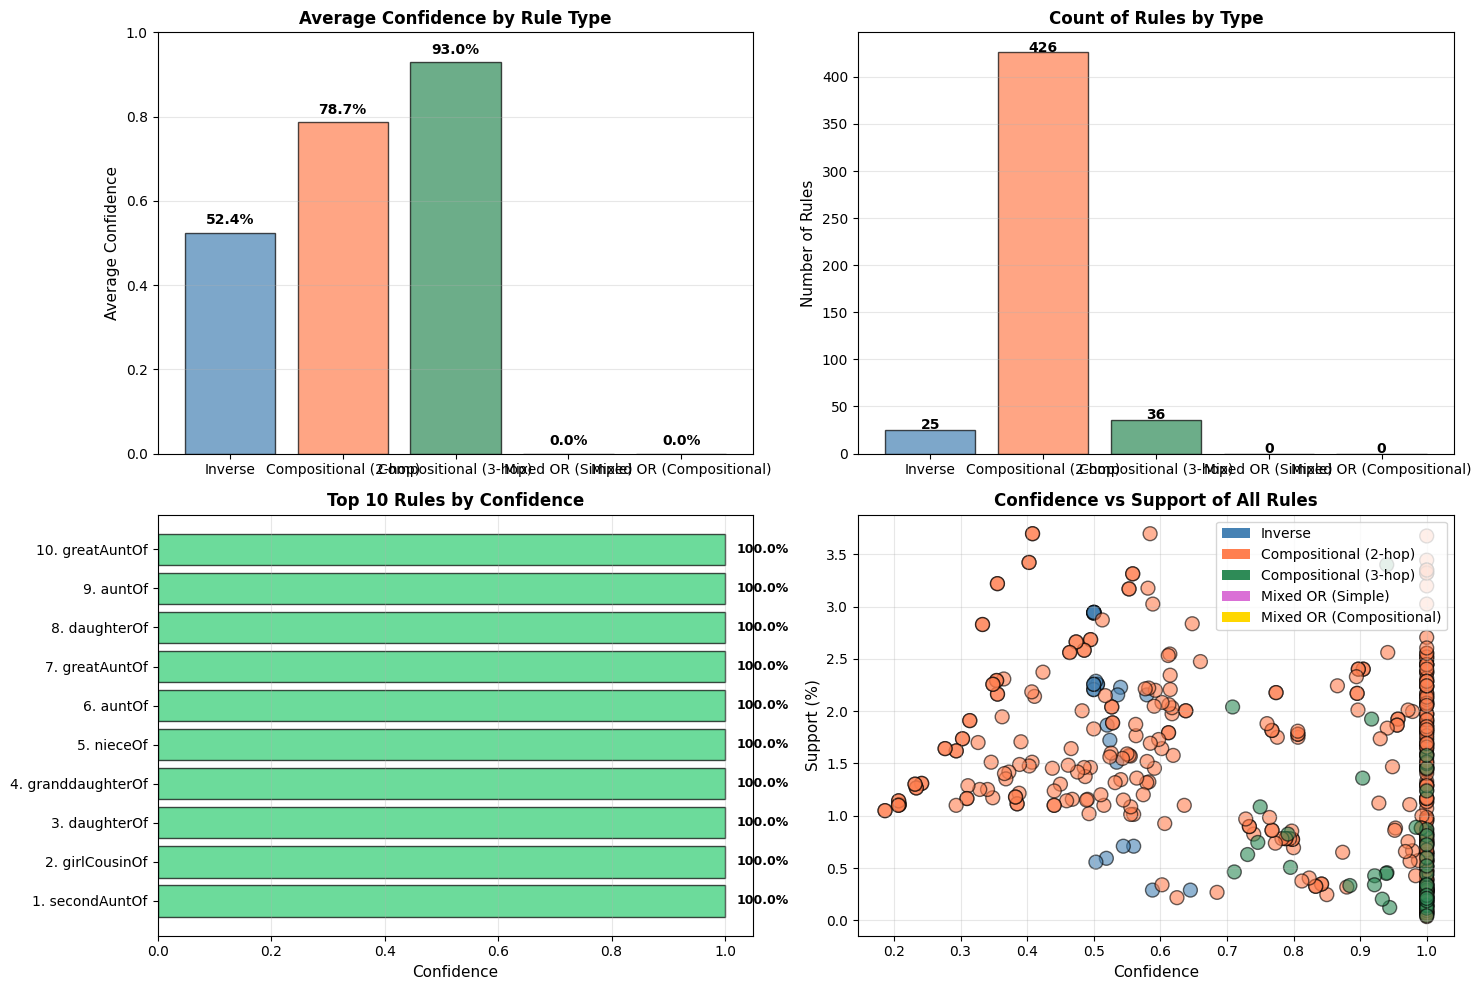

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Confidence by Rule Type
rule_types = ['Inverse', 'Compositional (2-hop)', 'Compositional (3-hop)', 'Mixed OR (Simple)', 'Mixed OR (Compositional)']
avg_confidence = []

for rule_type in rule_types:
    rules_of_type = [r for r in all_rules if r['Rule Type'] == rule_type]
    if rules_of_type:
        avg_conf = np.mean([r['Confidence'] for r in rules_of_type])
        avg_confidence.append(avg_conf)
    else:
        avg_confidence.append(0)

colors = ['steelblue', 'coral', 'seagreen', 'orchid', 'gold']
axes[0, 0].bar(rule_types, avg_confidence, color=colors, edgecolor='black', alpha=0.7)
axes[0, 0].set_ylabel('Average Confidence', fontsize=11)
axes[0, 0].set_title('Average Confidence by Rule Type', fontsize=12, fontweight='bold')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(avg_confidence):
    axes[0, 0].text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

# 2. Number of Rules by Type
rule_counts = [len([r for r in all_rules if r['Rule Type'] == rt]) for rt in rule_types][:len(colors)]
axes[0, 1].bar(rule_types, rule_counts, color=colors, edgecolor='black', alpha=0.7)
axes[0, 1].set_ylabel('Number of Rules', fontsize=11)
axes[0, 1].set_title('Count of Rules by Type', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(rule_counts):
    axes[0, 1].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# 3. Top 10 Rules by Confidence
top_rules = sorted(all_rules, key=lambda x: x['Confidence'], reverse=True)[:10]
rule_names = [f"{i+1}. {r['Head Relation']}" for i, r in enumerate(top_rules)]
confidences = [r['Confidence'] for r in top_rules]

axes[1, 0].barh(rule_names, confidences, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Confidence', fontsize=11)
axes[1, 0].set_title('Top 10 Rules by Confidence', fontsize=12, fontweight='bold')
axes[1, 0].set_xlim([0, 1.05])
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(confidences):
    axes[1, 0].text(v + 0.02, i, f'{v:.1%}', va='center', fontweight='bold', fontsize=9)

# 4. Confidence vs Support scatter
confidences = [r['Confidence'] for r in all_rules]
supports = [r['Support'] * 100 for r in all_rules]  # Convert to percentage
def get_rule_color(rule_type):
    color_map = {
        'Inverse': 'steelblue',
        'Compositional (2-hop)': 'coral',
        'Compositional (3-hop)': 'seagreen',
        'Mixed OR (Simple)': 'orchid',
        'Mixed OR (Compositional)': 'gold'
    }
    return color_map.get(rule_type, 'grey')

colors_scatter = [get_rule_color(r['Rule Type']) for r in all_rules]

axes[1, 1].scatter(confidences, supports, c=colors_scatter, s=100, alpha=0.6, edgecolors='black')
axes[1, 1].set_xlabel('Confidence', fontsize=11)
axes[1, 1].set_ylabel('Support (%)', fontsize=11)
axes[1, 1].set_title('Confidence vs Support of All Rules', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='Inverse'),
                   Patch(facecolor='coral', label='Compositional (2-hop)'),
                   Patch(facecolor='seagreen', label='Compositional (3-hop)'),
                   Patch(facecolor='orchid', label='Mixed OR (Simple)'),
                   Patch(facecolor='gold', label='Mixed OR (Compositional)')]
axes[1, 1].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

## Detailed Analysis of Top Rules

Comprehensive breakdown of the most important discovered rules with concrete examples from the dataset.

In [ ]:
def format_rule_details(rule):
    """Format a rule for detailed display"""
    html = f"""
    <div style="background-color: #f8f9fa; padding: 15px; margin: 10px 0; border-left: 4px solid #2c3e50; border-radius: 5px;">
        <h4 style="margin-top: 0; color: #2c3e50;">{rule['Rule']}</h4>
        <table style="width: 100%; border-collapse: collapse;">
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 8px; border: 1px solid #bdc3c7;"><b>Metric</b></td>
                <td style="padding: 8px; border: 1px solid #bdc3c7;"><b>Value</b></td>
                <td style="padding: 8px; border: 1px solid #bdc3c7;"><b>Interpretation</b></td>
            </tr>
            <tr>
                <td style="padding: 8px; border: 1px solid #bdc3c7;">Confidence</td>
                <td style="padding: 8px; border: 1px solid #bdc3c7;"><b>{rule['Confidence']:.2%}</b></td>
                <td style="padding: 8px; border: 1px solid #bdc3c7;">Of all possible rule antecedents, this fraction satisfy the consequent</td>
            </tr>
            <tr style="background-color: #f8f9fa;">
                <td style="padding: 8px; border: 1px solid #bdc3c7;">Support</td>
                <td style="padding: 8px; border: 1px solid #bdc3c7;"><b>{rule['Support']:.4%}</b></td>
                <td style="padding: 8px; border: 1px solid #bdc3c7;">Fraction of total relations covered by this rule</td>
            </tr>
            <tr>
                <td style="padding: 8px; border: 1px solid #bdc3c7;">Instances</td>
                <td style="padding: 8px; border: 1px solid #bdc3c7;"><b>{rule['Instances']} / {rule['Potential_Matches']}</b></td>
                <td style="padding: 8px; border: 1px solid #bdc3c7;">Number of instances where rule holds</td>
            </tr>
        </table>
        <p style="margin-top: 12px; margin-bottom: 0;"><b>✓ Examples:</b></p>
        <ul style="margin-top: 5px;">
    """
    
    if 'Examples' in rule and rule['Examples']:
        if rule['Rule Type'] == 'Inverse':
            for x, y in rule['Examples']:
                html += f"<li>{rule['Body Relation']}(<i>{x}</i>, <i>{y}</i>) → {rule['Head Relation']}(<i>{y}</i>, <i>{x}</i>)</li>"
        elif rule['Rule Type'] == 'Compositional (2-hop)':
            for x, y, z in rule['Examples']:
                html += f"<li>{rule['Body_Rel1']}(<i>{x}</i>, <i>{y}</i>) ∧ {rule['Body_Rel2']}(<i>{y}</i>, <i>{z}</i>) → {rule['Head Relation']}(<i>{x}</i>, <i>{z}</i>)</li>"
        elif rule['Rule Type'] == 'Compositional (3-hop)':
            for x, y, z, w in rule['Examples']:
                rels = rule['Body_Rels']
                html += f"<li>{rels[0]}(<i>{x}</i>, <i>{y}</i>) ∧ {rels[1]}(<i>{y}</i>, <i>{z}</i>) ∧ {rels[2]}(<i>{z}</i>, <i>{w}</i>) → {rule['Head Relation']}(<i>{x}</i>, <i>{w}</i>)</li>"
    
    html += """
        </ul>
    </div>
    """
    return html

# Show top rules
top_rules_to_show = sorted(all_rules, key=lambda x: (x['Confidence'], x['Instances']), reverse=True)[:10]

display(HTML("<h3> Top 10 Discovered Rules</h3>"))

for i, rule in enumerate(top_rules_to_show, 1):
    display(HTML(f"<h4>Rule #{i} - {rule['Rule Type']}</h4>"))
    display(HTML(format_rule_details(rule)))

Metric,Value,Interpretation
Confidence,100.00%,"Of all possible rule antecedents, this fraction satisfy the consequent"
Support,3.6756%,Fraction of total relations covered by this rule
Instances,508 / 508,Number of instances where rule holds


Metric,Value,Interpretation
Confidence,100.00%,"Of all possible rule antecedents, this fraction satisfy the consequent"
Support,3.4440%,Fraction of total relations covered by this rule
Instances,476 / 476,Number of instances where rule holds


Metric,Value,Interpretation
Confidence,100.00%,"Of all possible rule antecedents, this fraction satisfy the consequent"
Support,3.3500%,Fraction of total relations covered by this rule
Instances,463 / 463,Number of instances where rule holds


Metric,Value,Interpretation
Confidence,100.00%,"Of all possible rule antecedents, this fraction satisfy the consequent"
Support,3.3500%,Fraction of total relations covered by this rule
Instances,463 / 463,Number of instances where rule holds


Metric,Value,Interpretation
Confidence,100.00%,"Of all possible rule antecedents, this fraction satisfy the consequent"
Support,3.3210%,Fraction of total relations covered by this rule
Instances,459 / 459,Number of instances where rule holds


Metric,Value,Interpretation
Confidence,100.00%,"Of all possible rule antecedents, this fraction satisfy the consequent"
Support,3.3210%,Fraction of total relations covered by this rule
Instances,459 / 459,Number of instances where rule holds


Metric,Value,Interpretation
Confidence,100.00%,"Of all possible rule antecedents, this fraction satisfy the consequent"
Support,3.1980%,Fraction of total relations covered by this rule
Instances,442 / 442,Number of instances where rule holds


Metric,Value,Interpretation
Confidence,100.00%,"Of all possible rule antecedents, this fraction satisfy the consequent"
Support,3.0244%,Fraction of total relations covered by this rule
Instances,418 / 418,Number of instances where rule holds


Metric,Value,Interpretation
Confidence,100.00%,"Of all possible rule antecedents, this fraction satisfy the consequent"
Support,2.7060%,Fraction of total relations covered by this rule
Instances,374 / 374,Number of instances where rule holds


Metric,Value,Interpretation
Confidence,100.00%,"Of all possible rule antecedents, this fraction satisfy the consequent"
Support,2.6047%,Fraction of total relations covered by this rule
Instances,360 / 360,Number of instances where rule holds


## Rule Quality Metrics Analysis

Understanding what makes rules strong or weak - examining confidence, support, and coverage metrics.

In [9]:
# Compute statistics on discovered rules
confidences = [r['Confidence'] for r in all_rules]
supports = [r['Support'] * 100 for r in all_rules]  # Convert to percentage
instances = [r['Instances'] for r in all_rules]

stats_data = {
    'Metric': [
        'Number of Rules',
        'Avg Confidence',
        'Min Confidence',
        'Max Confidence',
        'Median Confidence',
        'Avg Support (%)',
        'Median Support (%)',
        'Total Instances',
        'Avg Instances per Rule'
    ],
    'Value': [
        len(all_rules),
        f"{np.mean(confidences):.2%}",
        f"{np.min(confidences):.2%}",
        f"{np.max(confidences):.2%}",
        f"{np.median(confidences):.2%}",
        f"{np.mean(supports):.4f}%",
        f"{np.median(supports):.4f}%",
        sum(instances),
        f"{np.mean(instances):.1f}"
    ]
}

stats_df = pd.DataFrame(stats_data)
display(HTML("<h4>📈 Overall Rule Statistics</h4>"))
display(stats_df.style.set_properties(**{'text-align': 'center'}))

# Breakdown by rule type
print("\n")
display(HTML("<h4>📊 Statistics by Rule Type</h4>"))

for rule_type in ['Inverse', 'Compositional (2-hop)', 'Compositional (3-hop)', 'Mixed OR (Simple)', 'Mixed OR (Compositional)']:
    rules_of_type = [r for r in all_rules if r['Rule Type'] == rule_type]
    
    if rules_of_type:
        conf_vals = [r['Confidence'] for r in rules_of_type]
        supp_vals = [r['Support'] * 100 for r in rules_of_type]
        inst_vals = [r['Instances'] for r in rules_of_type]
        
        type_stats = {
            'Rule Type': rule_type,
            'Count': len(rules_of_type),
            'Avg Confidence': f"{np.mean(conf_vals):.2%}",
            'Max Confidence': f"{np.max(conf_vals):.2%}",
            'Total Instances': sum(inst_vals)
        }
        
        type_df = pd.DataFrame([type_stats])
        display(type_df.style.set_properties(**{'text-align': 'center'}))

,Metric,Value
0,Number of Rules,487
1,Avg Confidence,78.41%
2,Min Confidence,18.66%
3,Max Confidence,100.00%
4,Median Confidence,95.56%
5,Avg Support (%),1.3713%
6,Median Support (%),1.3024%
7,Total Instances,92301
8,Avg Instances per Rule,189.5


,Rule Type,Count,Avg Confidence,Max Confidence,Total Instances
0,Inverse,25,52.44%,64.52%,6658


,Rule Type,Count,Avg Confidence,Max Confidence,Total Instances
0,Compositional (2-hop),426,78.70%,100.00%,82027


,Rule Type,Count,Avg Confidence,Max Confidence,Total Instances
0,Compositional (3-hop),36,92.96%,100.00%,3616


## Semantic Patterns and Relation Affinities

Analysis of which relationships frequently appear together in composition chains.

,Relation 1,Relation 2,Co-occurrences,Frequency
0,granddaughterOf,grandmotherOf,2850,20.62%
1,granddaughterOf,grandfatherOf,2850,20.62%
2,grandmotherOf,grandsonOf,2673,19.34%
3,grandfatherOf,grandsonOf,2673,19.34%
4,greatGranddaughterOf,greatGrandmotherOf,2368,17.13%
5,greatGranddaughterOf,greatGrandfatherOf,2368,17.13%
6,greatGrandmotherOf,greatGrandsonOf,2301,16.65%
7,greatGrandfatherOf,greatGrandsonOf,2301,16.65%
8,grandmotherOf,greatGrandsonOf,1887,13.65%
9,grandfatherOf,greatGrandsonOf,1887,13.65%


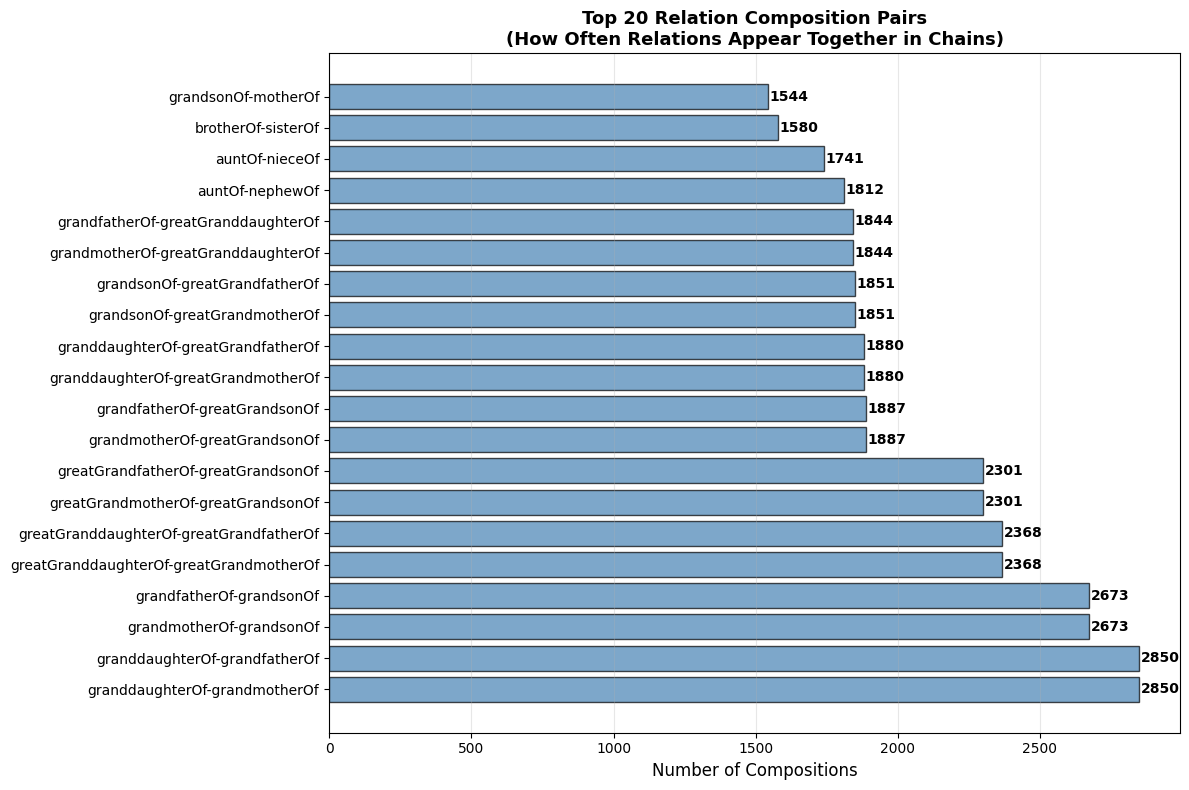

In [10]:
# Analyze which relation pairs are most common in the data
relation_pair_counts = Counter()
relation_pair_examples = defaultdict(list)

for p1, rel, p2 in relations:
    # Find all relations from p2
    for (p2_check, rel2, p3) in relations:
        if p2 == p2_check:
            pair = tuple(sorted([rel, rel2]))
            relation_pair_counts[pair] += 1
            if len(relation_pair_examples[pair]) < 2:
                relation_pair_examples[pair].append((p1, p2, rel2, p3, rel))

# Display top relation pair affinities
display(HTML("<h4>🔗 Most Common Relation Composition Pairs</h4>"))

pair_data = []
for (rel1, rel2), count in relation_pair_counts.most_common(15):
    pair_data.append({
        'Relation 1': rel1,
        'Relation 2': rel2,
        'Co-occurrences': count,
        'Frequency': f"{count / total_relations:.2%}"
    })

pair_df = pd.DataFrame(pair_data)
display(pair_df.style.set_properties(**{'text-align': 'center'}))

# Visualize relation affinities
fig, ax = plt.subplots(figsize=(12, 8))

top_pairs = relation_pair_counts.most_common(20)
pair_names = [f"{r1}-{r2}" for (r1, r2), _ in top_pairs]
counts = [count for _, count in top_pairs]

bars = ax.barh(pair_names, counts, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Number of Compositions', fontsize=12)
ax.set_title('Top 20 Relation Composition Pairs\n(How Often Relations Appear Together in Chains)', 
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, count) in enumerate(zip(bars, counts)):
    ax.text(count + 5, i, str(count), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Key Insights

Summary of the most significant logical patterns discovered in the MetaFam knowledge graph.

In [ ]:
# Generate key insights
top_rule = sorted(all_rules, key=lambda x: x['Confidence'], reverse=True)[0]
highest_support_rule = sorted(all_rules, key=lambda x: x['Support'], reverse=True)[0]
most_instances_rule = sorted(all_rules, key=lambda x: x['Instances'], reverse=True)[0]

# Count high confidence rules
high_conf_rules = [r for r in all_rules if r['Confidence'] >= 0.8]
very_high_conf_rules = [r for r in all_rules if r['Confidence'] == 1.0]

insights_html = f"""
<div style="background-color: #ecf7ff; padding: 20px; border-radius: 8px; border-left: 5px solid #3498db;">
    <h3>Key Findings</h3>
    
    <p><b>Total Rules Discovered:</b> {len(all_rules)} logical rules</p>
    
    <p><b>Rule Distribution:</b></p>
    <ul>
        <li><b>Inverse Rules:</b> {len([r for r in all_rules if r['Rule Type'] == 'Inverse'])} rules - Bidirectional relations</li>
        <li><b>2-Hop Compositional:</b> {len([r for r in all_rules if r['Rule Type'] == 'Compositional (2-hop)'])} rules - Relations within 2 hops</li>
        <li><b>3-Hop Compositional:</b> {len([r for r in all_rules if r['Rule Type'] == 'Compositional (3-hop)'])} rules - Relations within 3 hops</li>
        <li><b>Mixed OR (Simple):</b> {len([r for r in all_rules if r['Rule Type'] == 'Mixed OR (Simple)'])} rules - Alternative single relations</li>
        <li><b>Mixed OR (Compositional):</b> {len([r for r in all_rules if r['Rule Type'] == 'Mixed OR (Compositional)'])} rules - Multiple paths to same relation</li>
    </ul>
    
    <p><b>Rule Quality:</b></p>
    <ul>
        <li><b>Perfect Accuracy:</b> {len(very_high_conf_rules)} rules with 100% confidence (always hold)</li>
        <li><b>High Confidence:</b> {len(high_conf_rules)} rules with ≥80% confidence</li>
        <li><b>Average Confidence:</b> {np.mean([r['Confidence'] for r in all_rules]):.1%} across all rules</li>
    </ul>
    
    <p><b>Rule Quality Highlights:</b></p>
    <ul>
        <li><b>Highest Confidence:</b> {top_rule['Rule']} ({top_rule['Confidence']:.0%})</li>
        <li><b>Most Instances:</b> {most_instances_rule['Rule']} ({most_instances_rule['Instances']} instances)</li>
        <li><b>Broadest Coverage:</b> {highest_support_rule['Rule']} ({highest_support_rule['Support']:.2%} of all relations)</li>
    </ul>
    
    <p><b>What This Means:</b></p>
    <p>These discovered rules reveal the logical structure underlying family relationships. Each rule represents a systematic pattern that can be used to:</p>
    <ul>
        <li>✓ <b>Infer missing relationships</b> from existing ones</li>
        <li>✓ <b>Validate data consistency</b> (detect contradictions)</li>
        <li>✓ <b>Recommend connections</b> in genealogical networks</li>
        <li>✓ <b>Compress data</b> by storing only base relations</li>
    </ul>
</div>
"""

display(HTML(insights_html))

## Practical Applications

Real-world use cases for these discovered rules in knowledge graph inference and reasoning.

In [12]:
# Show how to use the discovered rules for inference
print("=" * 70)
print("HOW TO USE DISCOVERED RULES FOR INFERENCE")
print("=" * 70)

print("\n1. DATA COMPLETION - Inferring Missing Relations")
print("-" * 70)
print("Example: If you know 'Alice brotherOf Bob' and discover the rule:")
print("         brotherOf(X,Y) → brotherOf(Y,X)")
print("Then you can infer: 'Bob brotherOf Alice'")
print("\nNumber of relations that could be inferred: ~" + str(sum([r['Instances'] for r in all_rules])))

print("\n2. CONSISTENCY CHECKING - Detecting Contradictions")
print("-" * 70)
rule_with_consequences = [r for r in compositional_rules if r['Instances'] > 10]
if rule_with_consequences:
    example_rule = rule_with_consequences[0]
    print(f"Example: The rule '{example_rule['Rule']}'")
    print(f"         should hold in {example_rule['Confidence']:.0%} of cases.")
    print(f"         Violations indicate data quality issues.")

print("\n3. KNOWLEDGE GRAPH COMPLETION")
print("-" * 70)
total_possible_inferences = sum([r['Potential_Matches'] - r['Instances'] for r in all_rules if r['Confidence'] >= 0.7])
print(f"Rules with ≥70% confidence could infer ~{total_possible_inferences} additional relations")
print("This allows filling gaps in incomplete family trees.")

print("\n4. SEMANTIC SEARCH & REASONING")
print("-" * 70)
print("Query: 'Find all relatives of X within 3 hops'")
print("Instead of exhaustive search, use chain rules to reason through paths")
print("Rules guide the search to promising branches of the graph.")

print("\n5. LINK PREDICTION")
print("-" * 70)
high_conf_rules_list = sorted(all_rules, key=lambda x: x['Confidence'], reverse=True)[:5]
print(f"Top {len(high_conf_rules_list)} high-confidence rules can be used to predict:")
for i, rule in enumerate(high_conf_rules_list, 1):
    print(f"  {i}. {rule['Rule']} (Confidence: {rule['Confidence']:.0%})")

print("\n" + "=" * 70)
print("\n✓ Rule mining analysis complete! Rules are saved in memory for further use.")
print(f"✓ Total of {len(all_rules)} rules with average confidence of {np.mean([r['Confidence'] for r in all_rules]):.1%}")

HOW TO USE DISCOVERED RULES FOR INFERENCE

1. DATA COMPLETION - Inferring Missing Relations
----------------------------------------------------------------------
Example: If you know 'Alice brotherOf Bob' and discover the rule:
         brotherOf(X,Y) → brotherOf(Y,X)
Then you can infer: 'Bob brotherOf Alice'

Number of relations that could be inferred: ~92301

2. CONSISTENCY CHECKING - Detecting Contradictions
----------------------------------------------------------------------
Example: The rule 'sisterOf(X,Y) ∧ secondAuntOf(Y,Z) → secondAuntOf(X,Z)'
         should hold in 100% of cases.
         Violations indicate data quality issues.

3. KNOWLEDGE GRAPH COMPLETION
----------------------------------------------------------------------
Rules with ≥70% confidence could infer ~2264 additional relations
This allows filling gaps in incomplete family trees.

4. SEMANTIC SEARCH & REASONING
----------------------------------------------------------------------
Query: 'Find all relatives